# Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE


/tmp/ipykernel_4007/384002432.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('Data/Training/pair_features_1_pairs1_300_120.csv')
df.head()

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls
0,WELL,2001-02-08 00:00:00,18.850,18.710,61000.000,5.181,JBHT,4.797,4.656,348400.000,3.771,1.410,1.297,0.508,1.229,0.342,0.074
1,WELL,2001-02-09 00:00:00,18.900,18.620,78500.000,5.128,JBHT,4.781,4.656,1077600.000,3.859,1.269,1.298,0.508,1.217,0.330,0.066
2,WELL,2001-02-12 00:00:00,18.910,18.640,76700.000,5.142,JBHT,4.766,4.516,561600.000,3.859,1.283,1.299,0.507,1.204,0.314,0.065
3,WELL,2001-02-13 00:00:00,18.980,18.650,58600.000,5.197,JBHT,4.812,4.723,1248400.000,3.869,1.328,1.301,0.506,1.194,0.300,0.053
4,WELL,2001-02-14 00:00:00,19.000,18.870,75600.000,5.222,JBHT,4.812,4.656,446400.000,3.783,1.439,1.302,0.506,1.186,0.289,0.075


In [3]:
df['pnls'] = df['pnls']*100.0

In [4]:
total_days = df.Date.nunique()
total_days

5709

In [5]:
df.dropna()

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls
0,WELL,2001-02-08 00:00:00,18.850,18.710,61000.000,5.181,JBHT,4.797,4.656,348400.000,3.771,1.410,1.297,0.508,1.229,0.342,7.434
1,WELL,2001-02-09 00:00:00,18.900,18.620,78500.000,5.128,JBHT,4.781,4.656,1077600.000,3.859,1.269,1.298,0.508,1.217,0.330,6.571
2,WELL,2001-02-12 00:00:00,18.910,18.640,76700.000,5.142,JBHT,4.766,4.516,561600.000,3.859,1.283,1.299,0.507,1.204,0.314,6.492
3,WELL,2001-02-13 00:00:00,18.980,18.650,58600.000,5.197,JBHT,4.812,4.723,1248400.000,3.869,1.328,1.301,0.506,1.194,0.300,5.336
4,WELL,2001-02-14 00:00:00,19.000,18.870,75600.000,5.222,JBHT,4.812,4.656,446400.000,3.783,1.439,1.302,0.506,1.186,0.289,7.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,WELL,2023-10-12 00:00:00,85.410,84.310,2703400.000,83.851,JBHT,195.090,190.860,578800.000,192.031,108.180,106.505,7.981,109.405,5.969,0.000
5705,WELL,2023-10-13 00:00:00,85.680,84.590,2727100.000,83.999,JBHT,195.650,191.100,849200.000,190.567,106.569,106.520,7.977,109.031,5.524,0.000
5706,WELL,2023-10-16 00:00:00,85.980,84.530,2356400.000,84.512,JBHT,200.050,193.230,1028800.000,195.914,111.402,106.543,7.981,108.761,5.041,0.000
5707,WELL,2023-10-17 00:00:00,86.970,85.070,2182700.000,85.390,JBHT,200.200,195.550,1352400.000,195.147,109.757,106.551,7.983,108.493,4.595,0.000


## Technical Indicators

### Load SPY

In [6]:
# spy_df = pd.read_csv('Data/1999-12-01-2023-12-31_SPY.csv')
# spy_df = spy_df[['Date','Adj Close']]
# spy_df.columns = ['Date','SPY_Close']
# df = pd.merge(df,spy_df,on='Date',how='left')

In [7]:
# del spy_df
# gc.collect()

In [8]:
df = df.dropna()
df

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls
0,WELL,2001-02-08 00:00:00,18.850,18.710,61000.000,5.181,JBHT,4.797,4.656,348400.000,3.771,1.410,1.297,0.508,1.229,0.342,7.434
1,WELL,2001-02-09 00:00:00,18.900,18.620,78500.000,5.128,JBHT,4.781,4.656,1077600.000,3.859,1.269,1.298,0.508,1.217,0.330,6.571
2,WELL,2001-02-12 00:00:00,18.910,18.640,76700.000,5.142,JBHT,4.766,4.516,561600.000,3.859,1.283,1.299,0.507,1.204,0.314,6.492
3,WELL,2001-02-13 00:00:00,18.980,18.650,58600.000,5.197,JBHT,4.812,4.723,1248400.000,3.869,1.328,1.301,0.506,1.194,0.300,5.336
4,WELL,2001-02-14 00:00:00,19.000,18.870,75600.000,5.222,JBHT,4.812,4.656,446400.000,3.783,1.439,1.302,0.506,1.186,0.289,7.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,WELL,2023-10-12 00:00:00,85.410,84.310,2703400.000,83.851,JBHT,195.090,190.860,578800.000,192.031,108.180,106.505,7.981,109.405,5.969,0.000
5705,WELL,2023-10-13 00:00:00,85.680,84.590,2727100.000,83.999,JBHT,195.650,191.100,849200.000,190.567,106.569,106.520,7.977,109.031,5.524,0.000
5706,WELL,2023-10-16 00:00:00,85.980,84.530,2356400.000,84.512,JBHT,200.050,193.230,1028800.000,195.914,111.402,106.543,7.981,108.761,5.041,0.000
5707,WELL,2023-10-17 00:00:00,86.970,85.070,2182700.000,85.390,JBHT,200.200,195.550,1352400.000,195.147,109.757,106.551,7.983,108.493,4.595,0.000


### Beta

In [9]:
def compute_beta(rs,df,ticker,market):
    rows = df.loc[rs.index]
    sec_returns = np.log( df[[ticker,market]] / df[[ticker,market]].shift(1) ) 

    cov = sec_returns.cov() * 250
    cov_with_market = cov.iloc[0,1]
    market_var = sec_returns[market].var() * 250
    beta = cov_with_market / market_var
    return beta

In [10]:
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

2

### Single Ticker Features

In [11]:
df.columns

Index(['Ticker_P1', 'Date', 'High_P1', 'Low_P1', 'Volume_P1', 'Close_P1',
       'Ticker_P2', 'High_P2', 'Low_P2', 'Volume_P2', 'Close_P2', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_MA',
       'abs_spread_std_MA', 'pnls'],
      dtype='object')

In [12]:
df.sort_values('Date')

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls
0,WELL,2001-02-08 00:00:00,18.850,18.710,61000.000,5.181,JBHT,4.797,4.656,348400.000,3.771,1.410,1.297,0.508,1.229,0.342,7.434
1,WELL,2001-02-09 00:00:00,18.900,18.620,78500.000,5.128,JBHT,4.781,4.656,1077600.000,3.859,1.269,1.298,0.508,1.217,0.330,6.571
2,WELL,2001-02-12 00:00:00,18.910,18.640,76700.000,5.142,JBHT,4.766,4.516,561600.000,3.859,1.283,1.299,0.507,1.204,0.314,6.492
3,WELL,2001-02-13 00:00:00,18.980,18.650,58600.000,5.197,JBHT,4.812,4.723,1248400.000,3.869,1.328,1.301,0.506,1.194,0.300,5.336
4,WELL,2001-02-14 00:00:00,19.000,18.870,75600.000,5.222,JBHT,4.812,4.656,446400.000,3.783,1.439,1.302,0.506,1.186,0.289,7.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,WELL,2023-10-12 00:00:00,85.410,84.310,2703400.000,83.851,JBHT,195.090,190.860,578800.000,192.031,108.180,106.505,7.981,109.405,5.969,0.000
5705,WELL,2023-10-13 00:00:00,85.680,84.590,2727100.000,83.999,JBHT,195.650,191.100,849200.000,190.567,106.569,106.520,7.977,109.031,5.524,0.000
5706,WELL,2023-10-16 00:00:00,85.980,84.530,2356400.000,84.512,JBHT,200.050,193.230,1028800.000,195.914,111.402,106.543,7.981,108.761,5.041,0.000
5707,WELL,2023-10-17 00:00:00,86.970,85.070,2182700.000,85.390,JBHT,200.200,195.550,1352400.000,195.147,109.757,106.551,7.983,108.493,4.595,0.000


In [13]:
df.columns

Index(['Ticker_P1', 'Date', 'High_P1', 'Low_P1', 'Volume_P1', 'Close_P1',
       'Ticker_P2', 'High_P2', 'Low_P2', 'Volume_P2', 'Close_P2', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_MA',
       'abs_spread_std_MA', 'pnls'],
      dtype='object')

In [14]:
X = df[df.columns.drop('pnls')]
y = df['pnls']

X = X.drop(['Date', 'Ticker_P1', 'Ticker_P2'],axis=1)

In [15]:
X

,High_P1,Low_P1,Volume_P1,Close_P1,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA
0,18.850,18.710,61000.000,5.181,4.797,4.656,348400.000,3.771,1.410,1.297,0.508,1.229,0.342
1,18.900,18.620,78500.000,5.128,4.781,4.656,1077600.000,3.859,1.269,1.298,0.508,1.217,0.330
2,18.910,18.640,76700.000,5.142,4.766,4.516,561600.000,3.859,1.283,1.299,0.507,1.204,0.314
3,18.980,18.650,58600.000,5.197,4.812,4.723,1248400.000,3.869,1.328,1.301,0.506,1.194,0.300
4,19.000,18.870,75600.000,5.222,4.812,4.656,446400.000,3.783,1.439,1.302,0.506,1.186,0.289
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,85.410,84.310,2703400.000,83.851,195.090,190.860,578800.000,192.031,108.180,106.505,7.981,109.405,5.969
5705,85.680,84.590,2727100.000,83.999,195.650,191.100,849200.000,190.567,106.569,106.520,7.977,109.031,5.524
5706,85.980,84.530,2356400.000,84.512,200.050,193.230,1028800.000,195.914,111.402,106.543,7.981,108.761,5.041
5707,86.970,85.070,2182700.000,85.390,200.200,195.550,1352400.000,195.147,109.757,106.551,7.983,108.493,4.595


## Train test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [17]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

2019-04-08 00:00:00 2021-07-13 00:00:00


# Regression

In [18]:
# u = np.mean(y_train)
# s = np.std(y_train)
# y_train = y_train[(y_train>(u-2*s)) & (y_train<(u+2*s))]
# X_train = X_train.loc[y_train.index]

## Linear Regression

In [19]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
#Creating the LSTM model
class lstm(Model):
    def __init__(self, in_shape, look_back):
        super(lstm, self).__init__()
        self.shape = in_shape
        self.look_back = look_back
        self.lstm_l1 = LSTM(512, input_shape=self.shape, return_sequences = True)
#         self.lstm_l2 = LSTM(256)
        self.dropout = Dropout(0.2)
        self.dense = Dense(self.look_back)

    def call(self, x):
        x = self.lstm_l1(x)
#         x = self.lstm_l2(x)
        x = self.dropout(x)
        x = self.dense(x)
        return x

2024-03-16 05:43:37.307184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 05:43:38.047147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
# Reshape X for model training
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
valX = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1])).astype(np.float32)
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

In [21]:
#initializing the lstm model
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,\
                                            min_delta=0.001,restore_best_weights=True,verbose=1)

lstm_model = lstm((trainX.shape[1], trainX.shape[2]), look_back = 1)
lstm_model.compile(loss='mae', 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004), metrics=['mae'])
#fitting the model
history = lstm_model.fit(
                    trainX, 
                    y_train, 
                    epochs=40, 
                    batch_size=32,
                    validation_data=(valX, y_val), 
                    verbose=1, 
                    callbacks=callback,
                    shuffle=True)

Epoch 1/40


2024-03-16 05:43:38.849739: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


143/143 [==============================] - 3s 14ms/step - loss: 0.6624 - mae: 0.6624 - val_loss: 0.6215 - val_mae: 0.6215
Epoch 2/40
143/143 [==============================] - 2s 11ms/step - loss: 0.6399 - mae: 0.6399 - val_loss: 0.5783 - val_mae: 0.5783
Epoch 3/40
143/143 [==============================] - 2s 11ms/step - loss: 0.6147 - mae: 0.6147 - val_loss: 0.5518 - val_mae: 0.5518
Epoch 4/40
143/143 [==============================] - 2s 11ms/step - loss: 0.5902 - mae: 0.5902 - val_loss: 0.5432 - val_mae: 0.5432
Epoch 5/40
143/143 [==============================] - 2s 11ms/step - loss: 0.5700 - mae: 0.5700 - val_loss: 0.5515 - val_mae: 0.5515
Epoch 6/40
143/143 [==============================] - 2s 11ms/step - loss: 0.5506 - mae: 0.5506 - val_loss: 0.5356 - val_mae: 0.5356
Epoch 7/40
143/143 [==============================] - 2s 11ms/step - loss: 0.5329 - mae: 0.5329 - val_loss: 0.5334 - val_mae: 0.5334
Epoch 8/40
143/143 [==============================] - 2s 11ms/step - loss: 0.515

In [32]:
lstm_model.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               multiple                  1077248   
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  513       
                                                                 
Total params: 1077761 (4.11 MB)
Trainable params: 1077761 (4.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


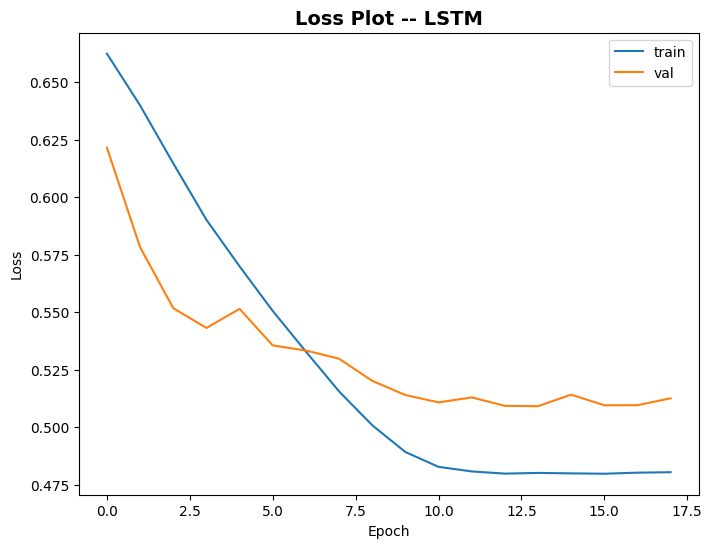

In [33]:
# Plot line graph to show amount loss according the the epoch
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Plot -- LSTM', fontsize=14, color="black", fontweight="bold")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
inference_result = lstm_model.predict(testX).flatten()

18/18 [==============================] - 0s 2ms/step


In [35]:
y_test.describe()

count   571.000
mean      0.202
std       0.953
min      -4.007
25%       0.000
50%       0.000
75%       0.000
max       4.784
Name: pnls, dtype: float64

In [36]:
pd.Series(inference_result).describe()

count   571.000
mean      0.000
std       0.002
min      -0.018
25%      -0.001
50%       0.000
75%       0.002
max       0.004
dtype: float64

In [37]:
lstm_mae = (inference_result - y_test).abs().mean()
lstm_mae

0.398807409098449

In [38]:
inference_result

array([-0.00135756, -0.00121034,  0.00041651, -0.00135756, -0.0009794 ,
       -0.00067704, -0.00116356, -0.00121034,  0.002077  ,  0.00153956,
       -0.00116356,  0.00134761,  0.00152651, -0.00135756,  0.002077  ,
        0.00118736,  0.00101995,  0.00152651, -0.00037006, -0.00104672,
        0.00224103,  0.00101497,  0.00003679, -0.00020011,  0.00044679,
        0.00134761,  0.002077  , -0.00400169,  0.00044679,  0.00044679,
        0.00003679,  0.002077  ,  0.00153956, -0.00121034,  0.00204534,
       -0.00046104,  0.00003679,  0.00123221,  0.00153956, -0.00067704,
        0.00123221,  0.00152651, -0.00037006, -0.00067704, -0.00067704,
        0.002077  ,  0.002077  ,  0.002077  ,  0.00134761,  0.002077  ,
        0.00123221,  0.00152651,  0.00207699,  0.00152651,  0.00153956,
       -0.00037006, -0.00116356, -0.00020011,  0.00134761, -0.00037006,
       -0.00008541, -0.00074981,  0.00081034, -0.00106615, -0.00056522,
       -0.00135756,  0.00102476,  0.00019137, -0.00096583, -0.00

In [39]:
mean_abs_label = ((y_test).mean() - y_test).abs().mean()
# lstm_mae / y_test.abs().mean()
lstm_mae / mean_abs_label

0.7509291560812243

In [30]:
# mae = (preds-y_test).abs().mean()
# mae

In [31]:
# mae/mean_abs_label